In [1]:
# 📦 Import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors

In [2]:
# Load training and testing datasets
train = pd.read_csv('train_loan_prediction.csv')
test = pd.read_csv('test_loan_prediction.csv')
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
# Drop Loan_ID
def tdrop(x):
    x.drop("Loan_ID", axis=1, inplace=True)

tdrop(train)

In [4]:
# Encode Loan_Status
train.replace({"Loan_Status": {'N': 0.0, 'Y': 1.0}}, inplace=True)

In [5]:
# Separate label and drop it from training set
label = train["Loan_Status"].values
train.drop(["Loan_Status"], axis=1, inplace=True)

In [6]:
# Fill missing values
def missvalue(a):
    cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
            'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
            'Loan_Amount_Term', 'Credit_History', 'Property_Area']
    for col in cols:
        if a[col].dtypes != 'O':
            med = a[col].median()
            a[col].fillna(med, inplace=True)
        else:
            mode = a[col].value_counts().index[0]
            a[col].fillna(mode, inplace=True)

missvalue(train)

In [7]:
# Split numerical and categorical features
def split(a):
    num = a.select_dtypes(include=[np.number])
    cat = a.select_dtypes(exclude=[np.number])
    cat = pd.get_dummies(cat)
    return num, cat

x, y = split(train)

In [8]:
# Insert label temporarily for correlation study
x.insert(5, "Loan_Status", label, True)
y.insert(15, "Loan_Status", label, True)

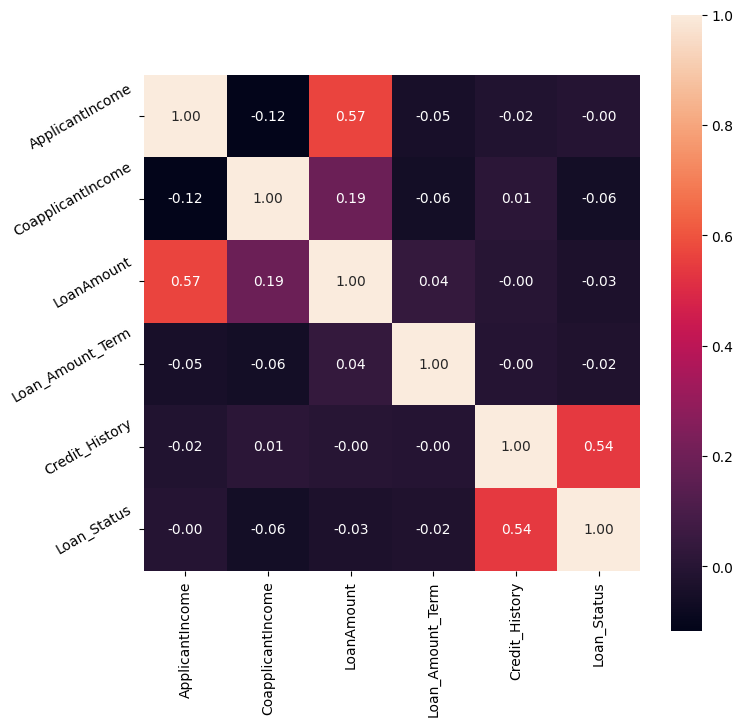

In [9]:
# Correlation Heatmap for Numerical Features
correlation = x.corr()
plt.figure(figsize=(8,8))
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)
plt.show()

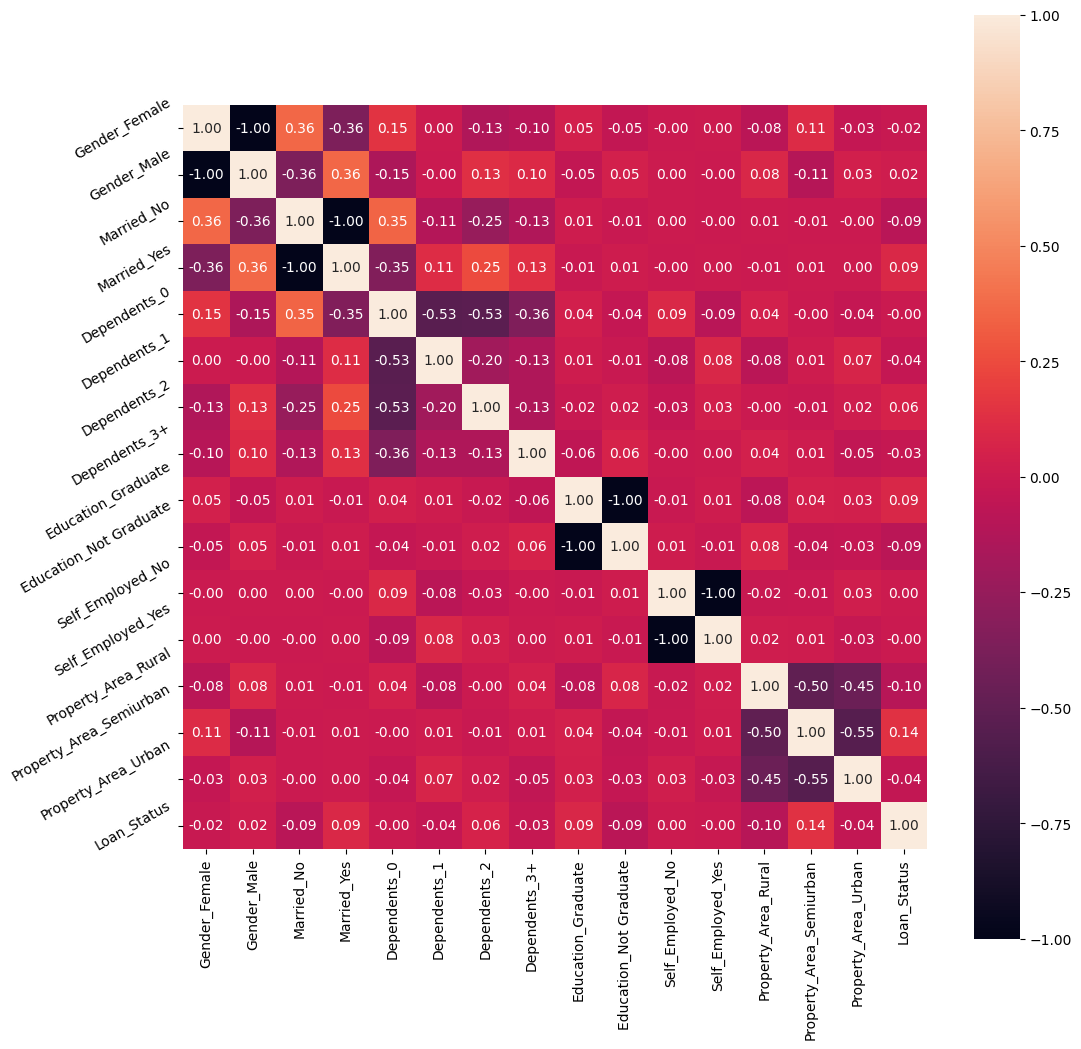

In [10]:
# Correlation Heatmap for Categorical Features (Optional — very big)
correlation = y.corr()
plt.figure(figsize=(12,12))
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)
plt.show()


In [11]:
# Drop less useful features
def fdrop(m, n):
    m.drop(["ApplicantIncome"], axis=1, inplace=True)
    n.drop(["Self_Employed_No"], axis=1, inplace=True)
    n.drop(["Dependents_0"], axis=1, inplace=True)
    n.drop(["Self_Employed_Yes"], axis=1, inplace=True)
    return m, n

x, y = fdrop(x, y)

In [12]:
# Drop Loan_Status from x and y after correlation
x.drop(["Loan_Status"], axis=1, inplace=True)
y.drop(["Loan_Status"], axis=1, inplace=True)

In [13]:
# Scale features
scaler = StandardScaler()

def scaling(x, y):
    features_scaled = scaler.fit_transform(x.values)
    q = y.values
    vk = np.concatenate((q, features_scaled), axis=1)
    return vk

features = scaling(x, y)

In [14]:
# Train-Test Split
np.random.seed(1234)
x_train, x_test, y_train, y_test = train_test_split(features, label, train_size=0.75, random_state=42)


In [15]:
# Model Training and Evaluation Functions
def train_and_evaluate(model, model_name):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print(f"\nModel: {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

In [16]:
# SVM - Linear
svc_linear = svm.SVC(kernel='linear', C=1.0)
train_and_evaluate(svc_linear, "SVM (Linear Kernel)")


Model: SVM (Linear Kernel)
Accuracy: 0.7727272727272727
Confusion Matrix:
 [[21 33]
 [ 2 98]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.39      0.55        54
         1.0       0.75      0.98      0.85       100

    accuracy                           0.77       154
   macro avg       0.83      0.68      0.70       154
weighted avg       0.81      0.77      0.74       154



In [17]:
# SVM - RBF
svc_rbf = svm.SVC(kernel='rbf', C=1.0)
train_and_evaluate(svc_rbf, "SVM (RBF Kernel)")


Model: SVM (RBF Kernel)
Accuracy: 0.7857142857142857
Confusion Matrix:
 [[22 32]
 [ 1 99]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      0.41      0.57        54
         1.0       0.76      0.99      0.86       100

    accuracy                           0.79       154
   macro avg       0.86      0.70      0.71       154
weighted avg       0.83      0.79      0.76       154



In [18]:
# Decision Tree
clf_tree = DecisionTreeClassifier(random_state=1)
train_and_evaluate(clf_tree, "Decision Tree")


Model: Decision Tree
Accuracy: 0.6623376623376623
Confusion Matrix:
 [[28 26]
 [26 74]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.52      0.52      0.52        54
         1.0       0.74      0.74      0.74       100

    accuracy                           0.66       154
   macro avg       0.63      0.63      0.63       154
weighted avg       0.66      0.66      0.66       154



In [19]:
# Random Forest
clf_rf = RandomForestClassifier(n_estimators=10, random_state=1)
train_and_evaluate(clf_rf, "Random Forest")


Model: Random Forest
Accuracy: 0.7597402597402597
Confusion Matrix:
 [[27 27]
 [10 90]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.50      0.59        54
         1.0       0.77      0.90      0.83       100

    accuracy                           0.76       154
   macro avg       0.75      0.70      0.71       154
weighted avg       0.76      0.76      0.75       154



In [20]:
# K-Nearest Neighbors
clf_knn = neighbors.KNeighborsClassifier(n_neighbors=10)
train_and_evaluate(clf_knn, "K-Nearest Neighbors")


Model: K-Nearest Neighbors
Accuracy: 0.7662337662337663
Confusion Matrix:
 [[23 31]
 [ 5 95]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.43      0.56        54
         1.0       0.75      0.95      0.84       100

    accuracy                           0.77       154
   macro avg       0.79      0.69      0.70       154
weighted avg       0.78      0.77      0.74       154



In [21]:
# Prepare Test Dataset (Apply Same Steps)
tdrop(test)
missvalue(test)
x_test_num, x_test_cat = split(test)
x_test_num, x_test_cat = fdrop(x_test_num, x_test_cat)
features_test = scaling(x_test_num, x_test_cat)

In [22]:
# Final Model Prediction on Test Data
final_model = svm.SVC(kernel='rbf', C=1.0)
final_model.fit(x_train, y_train)
final_predictions = final_model.predict(features_test)

In [23]:
# Output predictions
print("\nFinal Predictions on Test Set:")
print(final_predictions)


Final Predictions on Test Set:
[1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1.
 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0.
 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 0. 